In [50]:
from sklearn.ensemble.forest import _generate_unsampled_indices
from sklearn.ensemble.forest import _generate_sample_indices
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

from tqdm import tqdm

from itertools import permutations
import sys

import numpy as np
np.warnings.filterwarnings('ignore')

In [56]:
"""
This file contains code for conditional entropy forests. 
Adapted from https://github.com/rguo123/conditional_entropy_forests/blob/master/code/algorithm.py
"""

def finite_sample_correction(class_probs, row_sums):
    
    where_0 = np.argwhere(class_probs == 0)
    for elem in where_0:
        class_probs[elem[0], elem[1]] = 1 / (2 * row_sums[elem[0], None])
    where_1 = np.argwhere(class_probs == 1)
    for elem in where_1:
        class_probs[elem[0], elem[1]] = 1 - 1 / (2 * row_sums[elem[0], None])
    
    return class_probs

def build_model(X, y, n_estimators=200, max_samples=.32,
                                            bootstrap=True,
                                            depth=30,
                                            min_samples_leaf=1):
    if X.ndim == 1:
        raise ValueError('1d data will cause headaches down the road')
        
    max_features = int(np.ceil(np.sqrt(X.shape[1])))
        
    model=BaggingClassifier(DecisionTreeClassifier(max_depth=depth, min_samples_leaf=min_samples_leaf,
                                                     max_features = max_features),
                              n_estimators=n_estimators,
                              max_samples=max_samples,
                              bootstrap=bootstrap)
    
    model.fit(X, y)
    return model

def get_leaves(estimator):
    # adapted from https://scikit-learn.org/stable/auto_examples/tree/plot_unveil_tree_structure.html
    n_nodes = estimator.tree_.node_count
    children_left = estimator.tree_.children_left
    children_right = estimator.tree_.children_right
    feature = estimator.tree_.feature
    threshold = estimator.tree_.threshold
    
    leaf_ids = []
    stack = [(0, -1)] 
    while len(stack) > 0:
        node_id, parent_depth = stack.pop()

        # If we have a test node
        if (children_left[node_id] != children_right[node_id]):
            stack.append((children_left[node_id], parent_depth + 1))
            stack.append((children_right[node_id], parent_depth + 1))
        else:
            leaf_ids.append(node_id)
            
    return np.array(leaf_ids)

def estimate_posteriors(model, train, y, test, in_task=True, acorn=None):
    if acorn is None:
        acorn = np.random.randint(10**6)
    np.random.seed(acorn)
    
    n, d = train.shape
    m, d_ = test.shape
    
    if d != d_:
        raise ValueError("train and test data in different dimensions")
    
    class_counts = np.zeros((m, model.n_classes_))
    for tree in model:
        # get out of bag indicies
        if in_task:
            prob_indices = _generate_unsampled_indices(tree.random_state, n)
            # in_bag_idx = _generate_sample_indices(tree.random_state, n) # this is not behaving as i expected
        else:
            prob_indices = range(n)
            in_bag_idx = range(n)
        
        leaf_nodes = get_leaves(tree)
        unique_leaf_nodes = np.unique(leaf_nodes)
            
        # get all node counts
        node_counts = tree.tree_.n_node_samples
        # get probs for eval samples
        posterior_class_counts = np.zeros((len(unique_leaf_nodes), model.n_classes_))

        for prob_index in prob_indices:
            temp_node = tree.apply(train[prob_index].reshape(1, -1)).item()
            posterior_class_counts[np.where(unique_leaf_nodes == temp_node)[0][0], y[prob_index]] += 1
            
        # total number of points in a node
        row_sums = posterior_class_counts.sum(axis=1)
        
        # no divide by zero
        row_sums[row_sums == 0] = 1

        # posteriors
        class_probs = (posterior_class_counts / row_sums[:, None])
        # posteriors with finite sampling correction
        
        class_probs = finite_sample_correction(class_probs, row_sums)
    
        # posteriors as a list
        class_probs.tolist()
        
        partition_counts = np.asarray([node_counts[np.where(unique_leaf_nodes == x)[0][0]] for x in tree.apply(test)])
        # get probability for out of bag samples
        eval_class_probs = [class_probs[np.where(unique_leaf_nodes == x)[0][0]] for x in tree.apply(test)]
        eval_class_probs = np.array(eval_class_probs)
        # find total elements for out of bag samples
        elems = np.multiply(eval_class_probs, partition_counts[:, np.newaxis])
        # store counts for each x (repeat fhis for each tree)
        class_counts += elems
    # calculate p(y|X = x) for all x's
    probs = class_counts / class_counts.sum(axis=1, keepdims=True)
    
    return probs

def predict(a):
    return np.argmax(a, axis = 1)

def permutation(predict1, predict2):
    """
    how to use:
    
    this function returns the permutation i.e. \pi: [K] -> [K] that maximizes
    the number of matched predictions
    
    to use the permutation for posteriors for point i (posterior_i), say, simply use
    posterior_i[permutation]
    
    """
    unique_1 = np.unique(predict1)
    unique_2 = np.unique(predict2)
    
    if set(unique_1) != set(unique_2):
        raise ValueError("predictions must be on the same set of labels")
        
    K = len(unique_1)
    
    max_sum = 0
    max_perm = unique_2
    for i, perm in enumerate(permutations(unique_2)):
        perm = np.array(list(perm))
        temp_predict2 = -1*np.ones(len(predict2))
        
        for k in range(K):
            temp_predict2[np.where(predict2 == unique_2[k])[0]] = perm[k]
           
        temp_sum = np.sum(predict1 == temp_predict2)
        if temp_sum > max_sum:
            max_sum = temp_sum
            max_perm = perm
            
    return max_perm
            
def estimate_alpha(predict1, predict2, permutation=None):
    if permutation is None:
        return np.sum(predict1 == predict2) / len(predict1)
    else:
        unique = np.unique(temp_predict2)
        temp_predict2 = -1*np.ones(len(predict2))
        
        for i, k in enumerate(unique):
            temp_predict2[predict2 == k] = permutation[i]
            
        return np.sum(predict1 == temp_predict2) / len(predict1)
    
def generate_sample(n, pi, conditional_0, params0, conditional_1, params1, d = 2, acorn=None):
    if acorn is None:
        acorn = np.random.seed(10**6)
    np.random.seed(acorn)
    
    n0 = int(np.random.binomial(n, pi))
    n1 = n - n0
    ns = [n0, n1]
    
    X0 = conditional_0(*params0, size=(n0, d))
    
    X1 = conditional_1(*params1, size=(n1, d))
    
    labels = np.concatenate([i*np.ones(ns[i]) for i in range(len(ns))]).astype(int)
    
    return [np.concatenate((X0, X1), axis = 0), labels]

def generate_parity(n, d=2, invert_labels=False,acorn=None):
    if acorn is not None:
        np.random.seed(acorn)
        
    X = np.random.uniform(-1, 1, size=(n, d))
    Y = (np.sum(X > 0, axis=1) % 2 == 0).astype(int)
    
    if invert_labels:
        Y = -1 * (Y - 1)
    
    return X, Y

def parity_experiment(n, d, m, n_algos=4):
    T = int(np.floor(np.sqrt(n)))
    
    errors = np.zeros(n_algos)
    
    temp_predictions = [[] for __ in range(n_algos)]

    X, labelsX = generate_parity(n, d)
    testX, test_labelsX = generate_parity(m, d)

    Z, labelsZ = generate_parity(n, d, invert_labels=True)
    testZ, test_labelsZ = generate_parity(m, d, invert_labels=True)

    model_X = build_model(X, labelsX, T)
    model_Z = build_model(Z, labelsZ, T)

    posteriors_structX_estX=estimate_posteriors(model_X, X, labelsX, testX, in_task=True)
    posteriors_structZ_estX=estimate_posteriors(model_Z, X, labelsX, testX, in_task=False)

    pred_structX_estX=predict(posteriors_structX_estX)
    pred_structZ_estX=predict(posteriors_structZ_estX)

    posteriors_structX_estZ=estimate_posteriors(model_X, Z, labelsZ, testZ, in_task=False)
    posteriors_structZ_estZ=estimate_posteriors(model_Z, Z, labelsZ, testZ, in_task=True)

    # calculate errors without attempting to transfer knowledge
    pred_X = predict(posteriors_structX_estX)
    pred_Z = predict(posteriors_structZ_estZ)

    errors[0] = 1 - np.sum(test_labelsX == pred_X)/m
    errors[1] = 1 - np.sum(test_labelsZ == pred_Z)/m

    # jtv ?
    pred_X_jtv = predict(posteriors_structX_estX + posteriors_structZ_estX)
    pred_Z_jtv = predict(posteriors_structZ_estZ + posteriors_structX_estZ)

    errors[2] = 1 - np.sum(test_labelsX == pred_X_jtv)/m
    errors[3] = 1 - np.sum(test_labelsZ == pred_Z_jtv)/m

    return errors

In [55]:
condensed_func = lambda x : parity_experiment(x, 2, 100)
for i in range(10):
    condensed_func(100)

(100, 2) (100, 2)
(100, 2) (100, 2)
(100, 2) (100, 2)
(100, 2) (100, 2)
(100, 2) (100, 2)
(100, 2) (100, 2)
(100, 2) (100, 2)
(100, 2) (100, 2)
(100, 2) (100, 2)
(100, 2) (100, 2)


In [47]:
tests = []
for _ in range(10):
    temp = parity_experiment(10, 2)
    print(temp)
    tests.append(temp)

TypeError: parity_experiment() missing 1 required positional argument: 'm'

In [27]:
np.mean(tests, axis=0)

array([0.486, 0.523, 0.487, 0.548])

In [49]:
np.random.seed(1)
from joblib import Parallel, delayed

mc_its = 50 # number of simulation repititions
# ns0 = (10*np.arange(3,5,step=1)).astype(int)
ns1 = (100*np.arange(1, 3, step=0.5)).astype(int) # number of training samples 
# ns = np.concatenate((ns0, ns1))
ns = ns1
nz_prop = 1

m = 100 # number of test samples each monte carlo iteration

pi = 0.5

algorithms = ['task1', 'task2', 'task1 jtv', 'task2 jtv']
# algorithms = np.concatenate((algorithms, ['task1 cep local', 'task2 cep local', 'task1 jtv', 'task2 jtv']))
M = len(algorithms)

mean_error = np.zeros((len(algorithms), len(ns)))
std_error = np.zeros((len(algorithms), len(ns)))

d = 5
for j, n in enumerate(tqdm(ns)):
    errors = np.zeros((M, mc_its))
    
    k = int(np.floor(np.log(n)))
    T = int(np.floor(np.sqrt(n)))
    
    for i in range(mc_its):
        temp_predictions = [[] for __ in algorithms]
        
        X, labelsX = generate_parity(n, d)
        testX, test_labelsX = generate_parity(m, d)
        
        Z, labelsZ = generate_parity(n, d, invert_labels=True)
        testZ, test_labelsZ = generate_parity(m, d, invert_labels=True)
        
        model_X = build_model(X, labelsX)
        model_Z = build_model(Z, labelsZ)
        
        posteriors_structX_estX=estimate_posteriors(model_X, X, labelsX, testX, in_task=True)
        posteriors_structZ_estX=estimate_posteriors(model_Z, X, labelsX, testX, in_task=False)
        
        pred_structX_estX=predict(posteriors_structX_estX)
        pred_structZ_estX=predict(posteriors_structZ_estX)
        
        posteriors_structX_estZ=estimate_posteriors(model_X, Z, labelsZ, testZ, in_task=False)
        posteriors_structZ_estZ=estimate_posteriors(model_Z, Z, labelsZ, testZ, in_task=True)
        
        # calculate errors without attempting to transfer knowledge
        pred_X = predict(posteriors_structX_estX)
        pred_Z = predict(posteriors_structZ_estZ)
        
        errors[0, i] = 1 - np.sum(test_labelsX == pred_X)/m
        errors[1, i] = 1 - np.sum(test_labelsZ == pred_Z)/m
        
        # jtv ?
        pred_X_jtv = predict(posteriors_structX_estX + posteriors_structZ_estX)
        pred_Z_jtv = predict(posteriors_structZ_estZ + posteriors_structX_estZ)
        
        errors[2, i] = 1 - np.sum(test_labelsX == pred_X_jtv)/m
        errors[3, i] = 1 - np.sum(test_labelsZ == pred_Z_jtv)/m
    
    mean_error[:, j] = np.mean(errors, axis=1)
    std_error[:, j] = np.std(errors, ddof=1, axis=1)


  0%|          | 0/4 [00:00<?, ?it/s]

(100, 5)
(100, 5)
(100, 5)
(100, 5)
(100, 5)
(100, 5)


KeyboardInterrupt: 

Text(0.5, 1.0, 'parity and not parity, d=5')

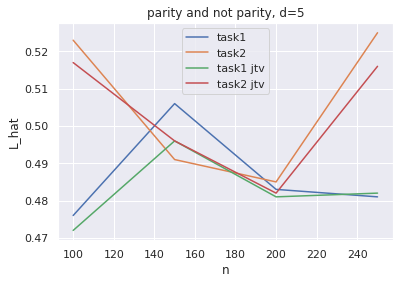

In [43]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

algo_offset = 0

fig, ax = plt.subplots(1,1)
for i, algo in enumerate(algorithms[algo_offset:]):
    ax.plot(ns, mean_error[i + algo_offset], label=algo)
ax.legend()
ax.set_xlabel('n')
ax.set_ylabel('L_hat')

ax.set_title('parity and not parity, d=%i'%(d))

In [23]:
X.shape

(200, 2)

In [75]:
from tqdm import tqdm_notebook as tqdm
np.random.seed(1)
from joblib import Parallel, delayed

mc_its = 200 # number of simulation repititions
# ns0 = (10*np.arange(3,5,step=1)).astype(int)
ns1 = (100*np.arange(1, 10, step=0.5)).astype(int) # number of training samples 
# ns = np.concatenate((ns0, ns1))
ns = ns1
nz_prop = 1

m = 100 # number of test samples each monte carlo iteration

algorithms = ['task1', 'task2', 'task1 jtv', 'task2 jtv']
# algorithms = np.concatenate((algorithms, ['task1 cep local', 'task2 cep local', 'task1 jtv', 'task2 jtv']))
M = len(algorithms)

mean_error = np.zeros((M, len(ns)))
std_error = np.zeros((M, len(ns)))

d = 2
for j, n in enumerate(tqdm(ns)):
    condensed_func = lambda x : parity_experiment(x, d, m)
    
    errors = np.array(Parallel(n_jobs=-2)(delayed(condensed_func)(int(x)) for x in n*np.ones(mc_it)))
    
    mean_error[:, j] = np.mean(errors, axis=0)
    std_error[:, j] = np.std(errors, ddof=1, axis=0)

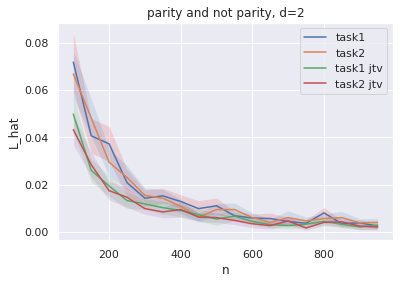

In [82]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

algo_offset = 0

sns.set()
colors = sns.color_palette("Set1", n_colors = M)
fig, ax = plt.subplots(1,1)
for i, algo in enumerate(algorithms[algo_offset:]):
    ax.plot(ns, mean_error[i + algo_offset], label=algo)
    ax.fill_between(ns, 
            mean_error[i] + 1.96*std_error[i]/np.sqrt(mc_it), 
            mean_error[i] - 1.96*std_error[i]/np.sqrt(mc_it), 
            where=mean_error[i] + 1.96*std_error[i]/np.sqrt(mc_it) >= mean_error[i] - 1.96*std_error[i]/np.sqrt(mc_it), 
            facecolor=colors[i], 
            alpha=0.15,
            interpolate=True)
ax.legend()
ax.set_xlabel('n')
ax.set_ylabel('L_hat')

ax.set_title('parity and not parity, d=%i'%(d))
plt.savefig('parity_not_parity_2d.png')

In [ ]:
# cep global
pred_structX_estZ=predict(posteriors_structX_estZ)
pred_structZ_estZ=predict(posteriors_structZ_estZ)

optimal_permutation_X = permutation(pred_structX_estX, pred_structZ_estX)
optimal_permutation_Z = permutation(pred_structZ_estZ, pred_structX_estZ)

new_posteriors_structX_estZ = np.zeros(posteriors_structX_estZ.shape)
new_posteriors_structZ_estX = np.zeros(posteriors_structZ_estX.shape)
for k in range(m):
    new_posteriors_structX_estZ[k] = posteriors_structX_estZ[k][optimal_permutation_X]
    new_posteriors_structZ_estX[k] = posteriors_structZ_estX[k][optimal_permutation_Z]

pred_structX_estZ = predict(posteriors_structX_estZ)
pred_structZ_estX = predict(posteriors_structZ_estX)

alpha_X = estimate_alpha(pred_structX_estX, pred_structZ_estX)
alpha_Z = estimate_alpha(pred_structZ_estZ, pred_structX_estZ)

pred_X_cep_global = predict(posteriors_structX_estX + alpha_X * new_posteriors_structZ_estX)
pred_Z_cep_global = predict(posteriors_structZ_estZ + alpha_Z * new_posteriors_structX_estZ)

errors[4, i] = 1 - np.sum(test_labelsX == pred_X_cep_global)/m
errors[5, i] = 1 - np.sum(test_labelsZ == pred_Z_cep_global)/m